<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
        Project - 3rd Phase
        <br />
        Image Colorization using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Tasks
<hr/>

1. Download the "landscape image colorization" dataset and slice it to `train_set`, `validation_set` and `test_set`.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to colorize grayscale images
3. plot learning curve and visualize grayscale images of test set, their corresponding color images and their colorized versions side by side.

# Method 1
<hr/>

## Import Necessary Libraries

In [1]:
import os
import re
import random
import numpy as np
import cv2
from PIL import Image
from skimage import io
from tqdm import tqdm  # For progress bars
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import keras

## Load Dataset and Prepare It

Loading the dataset into gray_images and color images: (Keep in mind that we first normalize all the pixels of image to be in the interval [0,1])

In [2]:
class ColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform_gray=None, transform_color=None):
        """
        Custom dataset class for image colorization.

        Args:
            gray_dir (str): Path to the directory containing grayscale images.
            color_dir (str): Path to the directory containing color images.
            transform_gray (callable, optional): Optional transform to be applied to grayscale images.
            transform_color (callable, optional): Optional transform to be applied to color images.
        """
        # Store directory paths and transformation functions
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.transform_gray = transform_gray
        self.transform_color = transform_color

        # List all image filenames in the grayscale and color directories
        self.gray_images = os.listdir(gray_dir)
        self.color_images = os.listdir(color_dir)

    def __len__(self):
        # Return the total number of grayscale images
        return len(self.gray_images)

    def __getitem__(self, idx):
        """
        Fetch a single grayscale image and its corresponding color image by index.

        Args:
            idx (int): Index of the image to fetch.

        Returns:
            Tuple[Tensor, Tensor]: Transformed grayscale image and corresponding color image.
        """
        # Get the file paths of the grayscale and color images
        gray_img_path = os.path.join(self.gray_dir, self.gray_images[idx])
        color_img_path = os.path.join(self.color_dir, self.color_images[idx])

        # Load grayscale image and convert to single channel ('L' mode)
        gray_image = Image.open(gray_img_path).convert("L")
        
        # Load color image and convert to RGB format (3 channels)
        color_image = Image.open(color_img_path).convert("RGB")

        # Apply transformations to grayscale and color images, if provided
        if self.transform_gray:
            gray_image = self.transform_gray(gray_image)
        if self.transform_color:
            color_image = self.transform_color(color_image)

        # Return the transformed grayscale and color image as a tuple
        return gray_image, color_image

def create_transforms():
    """
    Create image transformation pipelines for both grayscale and color images.
    
    The transforms resize the images, convert them to tensors, and normalize pixel values.
    
    Returns:
        Tuple[Compose, Compose]: Transformations for grayscale and color images.
    """
    # Grayscale transformation pipeline (Resize, convert to Tensor, normalize to [-1, 1])
    transform_gray = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize the image to 150x150 pixels
        transforms.ToTensor(),  # Convert image to a tensor with shape (1, H, W)
        transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale values with mean=0.5, std=0.5
    ])

    # Color transformation pipeline (Resize, convert to Tensor, normalize to [-1, 1])
    transform_color = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize the image to 150x150 pixels
        transforms.ToTensor(),  # Convert image to a tensor with shape (3, H, W)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB values with mean=0.5, std=0.5
    ])
    
    return transform_gray, transform_color

# Example usage function
def load_dataset(gray_dir, color_dir):
    """
    Load the dataset and split it into training, validation, and test sets.
    
    Args:
        gray_dir (str): Path to the directory of grayscale images.
        color_dir (str): Path to the directory of color images.
    
    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: DataLoaders for the training, validation, and test sets.
    """
    # Create the image transformations
    transform_gray, transform_color = create_transforms()

    # Initialize the dataset with transformations applied
    dataset = ColorizationDataset(gray_dir, color_dir,
                                  transform_gray=transform_gray, transform_color=transform_color)

    # Split the dataset into 70% training, 20% validation, and 10% testing
    train_size = int(0.7 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Use random_split to split the dataset into the three sets
    train_set, validation_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders for the train, validation, and test sets with batch size of 16
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)  # Shuffle for training
    val_loader = DataLoader(validation_set, batch_size=16)  # No shuffle for validation
    test_loader = DataLoader(test_set, batch_size=16)  # No shuffle for testing

    return train_loader, val_loader, test_loader

# Directories containing grayscale and color images
gray_dir = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
color_dir = '/kaggle/input/landscape-image-colorization/landscape Images/color'

# Load the dataset and split it into train, validation, and test DataLoaders
train_loader, val_loader, test_loader = load_dataset(gray_dir, color_dir)

## Define Your Model

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, dropout_rate=0.1):
        """
        Initializes the AutoEncoder with encoder and decoder layers and optional dropout for regularization.

        Args:
        dropout_rate (float): Dropout probability for regularization. Default is 0.1.
        """
        super(AutoEncoder, self).__init__()

        # Encoder (downsampling path)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # 1 input channel (grayscale), 64 output channels
            nn.BatchNorm2d(64),  # Normalize the activations for faster convergence
            nn.ReLU(inplace=True),  # Apply ReLU activation function for non-linearity

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Reduce height/width by 2 (stride=2)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Further downsample (reduce by half)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # Final downsampling to latent space
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Decoder (upsampling path)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample by 2
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Further upsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Continue upsampling
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Restore original resolution
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1),  # Output 3 channels (RGB image)
            nn.Sigmoid()  # Apply sigmoid to scale output between 0 and 1 (image pixel values)
        )

        # Dropout layer for regularization, helps to prevent overfitting during training
        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        """
        Defines the forward pass of the AutoEncoder, moving input through the encoder and decoder,
        and optionally applying dropout for regularization.

        Args:
        x (Tensor): Input tensor representing a batch of grayscale images.
        
        Returns:
        Tensor: The reconstructed (colorized) image.
        """

        # Pass input through the encoder (downsampling)
        for layer in self.encoder:
            x = layer(x)

        # Pass the encoded representation through the decoder (upsampling)
        for layer in self.decoder:
            x = layer(x)

        # Apply dropout to the final output
        decoded = self.dropout(x)

        return decoded

# Device configuration (CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the specified device
model = AutoEncoder().to(device)

## Fit The Model

Also Define optimizer, Criterion and other parameters 

In [4]:
# Function to train the model and track progress
def train_model(model, train_loader, val_loader, optimizer, n_epochs, device='cuda'):
    """
    Trains the given model using the provided training and validation data loaders.
    
    Args:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): DataLoader for the training dataset.
    val_loader (DataLoader): DataLoader for the validation dataset.
    optimizer (Optimizer): Optimizer to update model weights during training.
    n_epochs (int): Number of epochs for training.
    device (str): Device for training (either 'cuda' for GPU or 'cpu'). Default is 'cuda'.

    Returns:
    train_losses (list): List of average training losses for each epoch.
    val_losses (list): List of average validation losses for each epoch.
    """
    
    train_losses = []  # To store the average training loss for each epoch
    val_losses = []  # To store the average validation loss for each epoch
    
    # Loop over the specified number of epochs
    for epoch in range(n_epochs):
        model.train()  # Set model to training mode (enables dropout, batchnorm, etc.)
        running_train_loss = 0.0  # Accumulate training loss over each batch
        
        # Iterate over the batches in the training set
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            inputs, targets = batch  # Extract input images and their corresponding target labels
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device

            optimizer.zero_grad()  # Clear gradients from the previous step
            outputs = model(inputs)  # Forward pass through the model
            
            # Compute the loss between the model outputs and the target images (using MSELoss here)
            loss = nn.MSELoss()(outputs, targets)
            loss.backward()  # Backpropagate the error to compute gradients
            optimizer.step()  # Update model parameters based on computed gradients

            running_train_loss += loss.item()  # Accumulate batch loss for the epoch

        # Compute and store the average training loss for this epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase: disable gradient computations for faster inference
        model.eval()  # Set model to evaluation mode (disables dropout, batchnorm, etc.)
        running_val_loss = 0.0  # Accumulate validation loss
        
        with torch.no_grad():  # No need to track gradients during validation
            for batch in val_loader:
                inputs, targets = batch  # Get validation inputs and targets
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device

                outputs = model(inputs)  # Forward pass through the model
                loss = nn.MSELoss()(outputs, targets)  # Compute validation loss (MSE in this case)
                running_val_loss += loss.item()  # Accumulate validation loss

        # Compute and store the average validation loss for this epoch
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Print the training and validation loss for the current epoch
        print(f'Epoch [{epoch+1}/{n_epochs}] -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses  # Return lists of training and validation losses for each epoch

# Example usage: defining the optimizer and training the model
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)  # Use Adagrad optimizer with learning rate of 1e-3
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, n_epochs=20, device=device)  # Train the model for 20 epochs

Epoch 1/20: 100%|██████████| 312/312 [01:38<00:00,  3.18it/s]


Epoch [1/20] -> Train Loss: 0.2823, Val Loss: 0.2272


Epoch 2/20: 100%|██████████| 312/312 [00:38<00:00,  8.15it/s]


Epoch [2/20] -> Train Loss: 0.2458, Val Loss: 0.2225


Epoch 3/20: 100%|██████████| 312/312 [00:38<00:00,  8.03it/s]


Epoch [3/20] -> Train Loss: 0.2408, Val Loss: 0.2196


Epoch 4/20: 100%|██████████| 312/312 [00:38<00:00,  8.04it/s]


Epoch [4/20] -> Train Loss: 0.2390, Val Loss: 0.2177


Epoch 5/20: 100%|██████████| 312/312 [00:38<00:00,  8.13it/s]


Epoch [5/20] -> Train Loss: 0.2371, Val Loss: 0.2163


Epoch 6/20: 100%|██████████| 312/312 [00:36<00:00,  8.54it/s]


Epoch [6/20] -> Train Loss: 0.2365, Val Loss: 0.2153


Epoch 7/20: 100%|██████████| 312/312 [00:35<00:00,  8.73it/s]


Epoch [7/20] -> Train Loss: 0.2356, Val Loss: 0.2140


Epoch 8/20: 100%|██████████| 312/312 [00:36<00:00,  8.66it/s]


Epoch [8/20] -> Train Loss: 0.2349, Val Loss: 0.2136


Epoch 9/20: 100%|██████████| 312/312 [00:35<00:00,  8.74it/s]


Epoch [9/20] -> Train Loss: 0.2348, Val Loss: 0.2140


Epoch 10/20: 100%|██████████| 312/312 [00:36<00:00,  8.63it/s]


Epoch [10/20] -> Train Loss: 0.2337, Val Loss: 0.2142


Epoch 11/20: 100%|██████████| 312/312 [00:36<00:00,  8.55it/s]


Epoch [11/20] -> Train Loss: 0.2337, Val Loss: 0.2128


Epoch 12/20: 100%|██████████| 312/312 [00:36<00:00,  8.64it/s]


Epoch [12/20] -> Train Loss: 0.2330, Val Loss: 0.2124


Epoch 13/20: 100%|██████████| 312/312 [00:36<00:00,  8.62it/s]


Epoch [13/20] -> Train Loss: 0.2330, Val Loss: 0.2116


Epoch 14/20: 100%|██████████| 312/312 [00:36<00:00,  8.65it/s]


Epoch [14/20] -> Train Loss: 0.2324, Val Loss: 0.2114


Epoch 15/20: 100%|██████████| 312/312 [00:36<00:00,  8.62it/s]


Epoch [15/20] -> Train Loss: 0.2323, Val Loss: 0.2116


Epoch 16/20: 100%|██████████| 312/312 [00:35<00:00,  8.76it/s]


Epoch [16/20] -> Train Loss: 0.2317, Val Loss: 0.2122


Epoch 17/20: 100%|██████████| 312/312 [00:35<00:00,  8.77it/s]


Epoch [17/20] -> Train Loss: 0.2319, Val Loss: 0.2103


Epoch 18/20: 100%|██████████| 312/312 [00:36<00:00,  8.62it/s]


Epoch [18/20] -> Train Loss: 0.2316, Val Loss: 0.2110


Epoch 19/20: 100%|██████████| 312/312 [00:35<00:00,  8.70it/s]


Epoch [19/20] -> Train Loss: 0.2318, Val Loss: 0.2109


Epoch 20/20: 100%|██████████| 312/312 [00:36<00:00,  8.66it/s]


Epoch [20/20] -> Train Loss: 0.2310, Val Loss: 0.2106


## Visualize Learning Curves

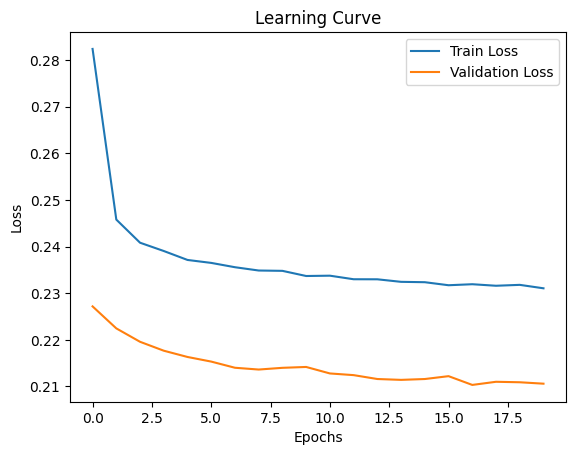

In [5]:
# plot_learning_curve(train_losses, val_losses)
def plot_learning_curve(train_losses, val_losses):
    """
    Plots the learning curves for training and validation losses over the course of training.
    
    Args:
    train_losses (list): A list of training losses recorded at the end of each epoch.
    val_losses (list): A list of validation losses recorded at the end of each epoch.
    """
    # Plot the training loss over epochs
    plt.plot(train_losses, label='Train Loss')
    # Plot the validation loss over epochs
    plt.plot(val_losses, label='Validation Loss')
    # Set the x-axis label as 'Epochs' to show the progress of training over time
    plt.xlabel('Epochs')
    # Set the y-axis label as 'Loss' to indicate the scale of the loss values
    plt.ylabel('Loss')
    # Add a title to the plot indicating it's a learning curve
    plt.title('Learning Curve')
    # Add a legend to differentiate between training and validation losses
    plt.legend()
    # Display the plot
    plt.show()

# Call the function to plot the learning curve using training and validation losses
plot_learning_curve(train_losses, val_losses)

## Plot The Results

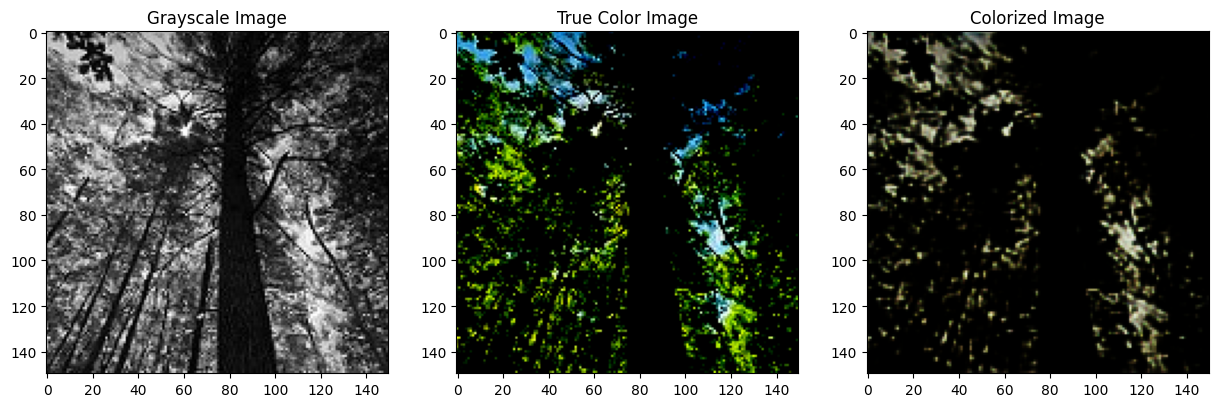

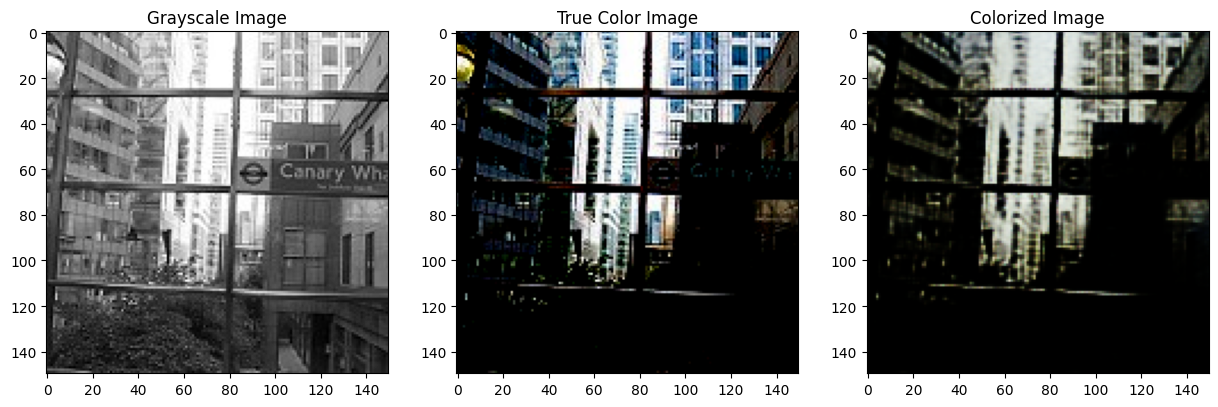

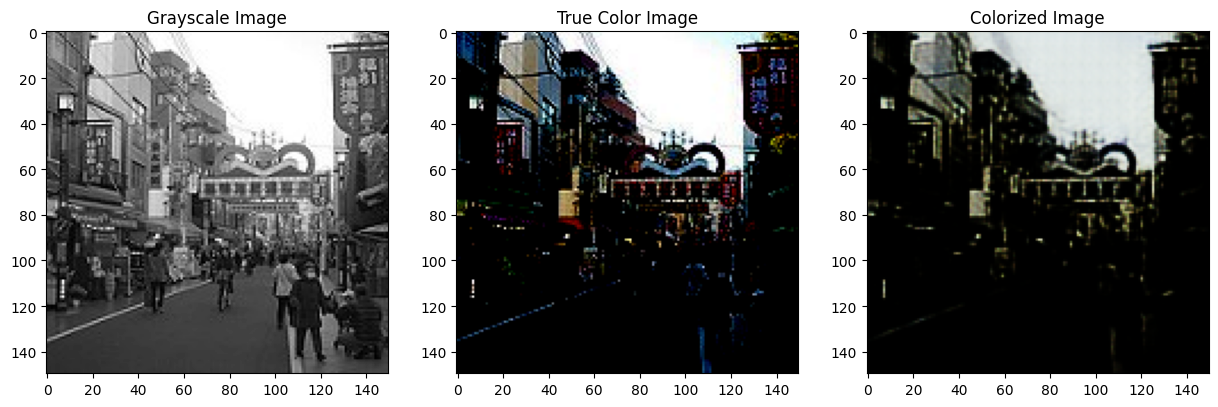

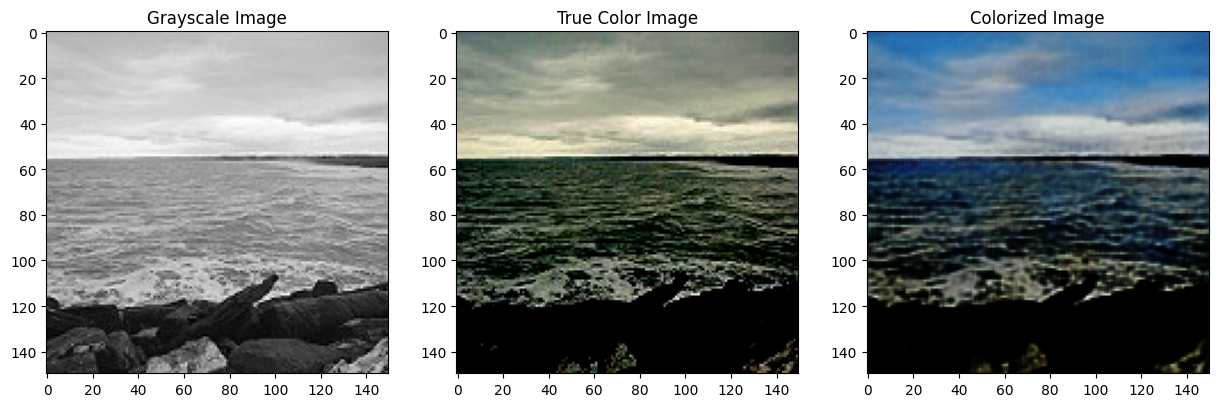

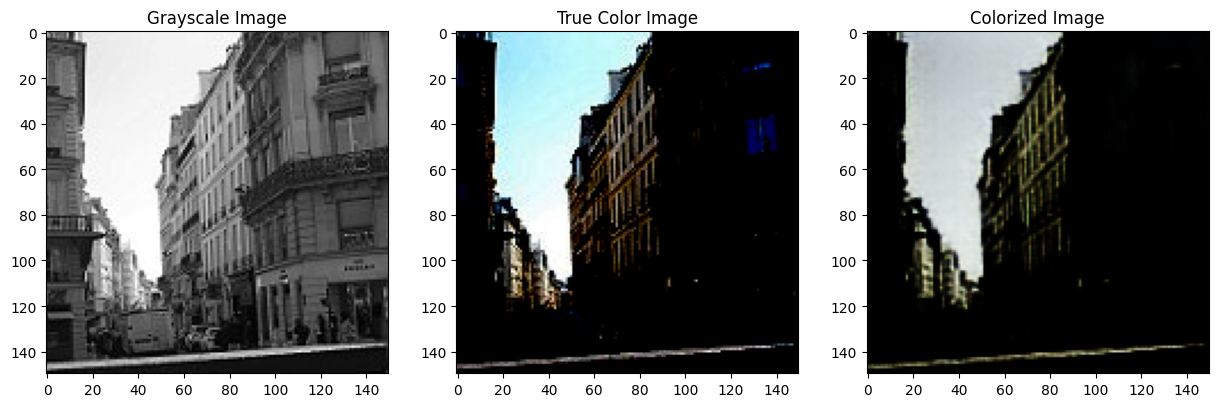

In [6]:
def visualize_results(model, test_loader):
    """
    Visualizes the output of the model by comparing grayscale inputs, true color images, and the colorized outputs.
    
    Args:
    model (nn.Module): The trained model used to predict colorized images from grayscale inputs.
    test_loader (DataLoader): DataLoader for the test dataset, containing grayscale inputs and true color images.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    # Disable gradient calculation to speed up inference and reduce memory usage
    with torch.no_grad():
        # Loop through the test_loader to get batches of grayscale and true color images
        for gray_images, color_images in test_loader:
            # Move the grayscale input images to the specified device (e.g., GPU or CPU)
            gray_images = gray_images.to(device)
            # Use the trained model to predict colorized outputs from grayscale inputs
            outputs = model(gray_images)
            # Randomly select 5 images from the batch for visualization
            indices = random.sample(range(len(gray_images)), 5)
            for i in indices:
                # Convert the grayscale image to a format suitable for visualization (H x W)
                grayscale = gray_images[i].cpu().numpy().transpose(1, 2, 0).squeeze()
                # Convert the true color image (ground truth) to RGB for display (H x W x C)
                true_color = color_images[i].cpu().numpy().transpose(1, 2, 0)
                # Convert the model's predicted colorized output to RGB format for display (H x W x C)
                colorized = outputs[i].cpu().numpy().transpose(1, 2, 0)
                # Create a figure with 3 subplots: grayscale input, true color image, and the model's colorized output
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                # Display the grayscale input image on the first subplot
                axs[0].imshow(grayscale, cmap='gray')
                axs[0].set_title('Grayscale Image')
                # Display the true color image (ground truth) on the second subplot
                axs[1].imshow(true_color)
                axs[1].set_title('True Color Image')
                # Display the colorized image produced by the model on the third subplot
                axs[2].imshow(colorized)
                axs[2].set_title('Colorized Image')
                # Show the figure
                plt.show()
            break  # Visualize results for just one batch and stop

# Call the function to visualize model predictions on the test dataset
visualize_results(model, test_loader)

# Method 2
<hr/>

## Import Necessary Libraries

In [7]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

## Load Dataset and Prepare It

In [8]:
# Function to perform histogram equalization on an image
# This enhances the contrast of an image by redistributing pixel intensities.
def equalize_histogram(image):
    image = np.array(image)  # Convert input image to a NumPy array for processing
    for i in range(3):  # Loop over each channel (Red, Green, Blue)
        image[:, :, i] = cv2.equalizeHist(image[:, :, i])  # Apply histogram equalization to each channel
    return Image.fromarray(image)  # Convert the NumPy array back to an image and return

# Dataset class for loading grayscale and color images for colorization task
class ColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform_gray=None, transform_color=None):
        self.gray_images = sorted(os.listdir(gray_dir))  # List of grayscale image filenames sorted alphabetically
        self.color_images = sorted(os.listdir(color_dir))  # List of color image filenames sorted alphabetically
        self.gray_dir = gray_dir  # Directory containing grayscale images
        self.color_dir = color_dir  # Directory containing color images
        self.transform_gray = transform_gray  # Transformation to apply to grayscale images (if any)
        self.transform_color = transform_color  # Transformation to apply to color images (if any)

    def __len__(self):
        # Return the total number of images in the dataset (assuming grayscale and color directories are aligned)
        return len(self.gray_images)

    def __getitem__(self, idx):
        # Load grayscale image at the given index and convert it to 'L' mode (grayscale)
        gray_image_path = os.path.join(self.gray_dir, self.gray_images[idx])
        gray_image = Image.open(gray_image_path).convert('L')

        # Load corresponding color image at the given index and convert it to 'RGB' mode (color)
        color_image_path = os.path.join(self.color_dir, self.color_images[idx])
        color_image = Image.open(color_image_path).convert('RGB')

        # Apply transformation to the grayscale image, if provided
        if self.transform_gray:
            gray_image = self.transform_gray(gray_image)

        # Apply transformation to the color image, if provided
        if self.transform_color:
            color_image = self.transform_color(color_image)

        # Return the grayscale and color images as a pair (input and target)
        return gray_image, color_image

# Function to create transforms for training and validation sets
# These include resizing, normalization, and data augmentation (e.g., random horizontal flipping)
def create_train_val_transforms():
    transform_gray = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize grayscale images to 150x150
        transforms.ToTensor(),  # Convert grayscale image to a PyTorch tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
    ])
    
    transform_color = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize color images to 150x150
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% chance
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # Randomly adjust brightness, contrast, and hue
        transforms.ToTensor()  # Convert color image to a PyTorch tensor
    ])
    
    return transform_gray, transform_color

# Function to create simpler transforms for the test set (no data augmentation)
# Test set uses straightforward resizing and normalization without random augmentations
def create_test_transforms():
    transform_gray = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize grayscale images to 150x150
        transforms.ToTensor(),  # Convert grayscale image to a PyTorch tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
    ])
    
    transform_color = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize color images to 150x150
        transforms.ToTensor()  # Convert color image to a PyTorch tensor
    ])
    
    return transform_gray, transform_color

# Function to load datasets and create DataLoaders for train, validation, and test sets
def load_dataset(gray_dir, color_dir):
    # Create transformations for the training and validation datasets
    train_val_transform_gray, train_val_transform_color = create_train_val_transforms()
    # Create transformations for the test dataset (simpler, no data augmentation)
    test_transform_gray, test_transform_color = create_test_transforms()
    
    # Create the dataset object for training and validation (with augmentation and normalization)
    full_dataset_train_val = ColorizationDataset(gray_dir, color_dir, 
                                                 transform_gray=train_val_transform_gray, 
                                                 transform_color=train_val_transform_color)
    
    # Create the dataset object for testing (with simpler transformations)
    full_dataset_test = ColorizationDataset(gray_dir, color_dir, 
                                            transform_gray=test_transform_gray, 
                                            transform_color=test_transform_color)

    # Determine the sizes for training, validation, and test sets (70%, 20%, 10% splits)
    train_size = int(0.7 * len(full_dataset_train_val))  # 70% for training
    val_size = int(0.2 * len(full_dataset_train_val))  # 20% for validation
    test_size = len(full_dataset_train_val) - train_size - val_size  # Remaining 10% for testing

    # Split the dataset into training, validation, and test sets
    train_set, validation_set, test_set = random_split(full_dataset_train_val, [train_size, val_size, test_size])
    
    # Use the full test dataset with the simpler test transformations
    test_set = full_dataset_test  # Overwrite test set to use test-specific transformations

    # Create DataLoaders for each dataset, setting batch sizes and shuffle options
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)  # Shuffle training data for randomness
    val_loader = DataLoader(validation_set, batch_size=16)  # No need to shuffle validation data
    test_loader = DataLoader(test_set, batch_size=32)  # Larger batch size for test set (since we don't need gradients)

    return train_loader, val_loader, test_loader

# Example usage of the dataset loading function
gray_dir = '/kaggle/input/landscape-image-colorization/landscape Images/gray'  # Directory containing grayscale images
color_dir = '/kaggle/input/landscape-image-colorization/landscape Images/color'  # Directory containing color images
train_loader, val_loader, test_loader = load_dataset(gray_dir, color_dir)  # Load DataLoaders for train, validation, and test sets

## Define Your Model

In [9]:
class UNetAutoEncoder(nn.Module):
    def __init__(self):
        super(UNetAutoEncoder, self).__init__()

        # Encoder: progressively reduces the spatial dimensions while increasing feature depth
        # First block: input is a single-channel grayscale image (1 channel), output is 64 feature maps
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # 3x3 convolution, stride 1 keeps dimensions, padding 1 ensures size is preserved
            nn.BatchNorm2d(64),  # Batch normalization for more stable training
            nn.ReLU(inplace=True),  # Activation function for introducing non-linearity

            # Second block: reduces spatial dimensions by half (stride=2), increases feature depth to 128
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Convolution with stride 2, halving the spatial resolution
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Third block: further reduces spatial dimensions by half (stride=2), increases feature depth to 256
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Another downsampling with increased feature depth
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Middle part (bottleneck): processes the highly compressed feature maps
        # This is the transition between the encoder (downsampling) and decoder (upsampling)
        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Keeps the spatial dimensions the same
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Decoder: progressively increases the spatial dimensions back to the original size while reducing feature depth
        # First block: upsamples feature maps back to the size of the second-to-last encoder output
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsampling by a factor of 2
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Second block: upsamples to match the size of the first encoder output
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Another upsampling by a factor of 2
            nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),  # Activation function (commented out, likely intended to be included for consistency)

            # Final convolution: reduces the number of channels to 3 (for RGB output), no padding or stride change
            nn.Conv2d(64, 3, kernel_size=3, stride=1),  # Final output, mapping 64 feature maps to 3-channel RGB image
            nn.Sigmoid()  # Sigmoid activation for outputting values between 0 and 1 (normalized RGB image)
        )

    def forward(self, x):
        # Encoder pass: downsampling the input image while capturing important features
        enc = self.encoder(x)

        # Middle (bottleneck) pass: processes the compressed representation
        mid = self.middle(enc)

        # Decoder pass: upsampling the image back to its original dimensions
        # Skip connection: adds the encoder's output (enc) to the decoder's input (mid) to combine detailed information
        dec = self.decoder(mid + enc)

        # Return the final reconstructed RGB image
        return dec
    
# Set the device to GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the UNet model and move it to the appropriate device (GPU or CPU)
model = UNetAutoEncoder().to(device)

## Fit The Model

In [10]:
# Defines a perceptual loss class utilizing a pre-trained VGG16 network to compute high-level feature losses
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()

        # Load the pre-trained VGG16 model, only the convolutional feature extractor layers are used
        vgg = models.vgg16(pretrained=True).features
        
        # Retain layers up to the 4th max-pooling layer (pool4), which captures deeper features
        self.vgg_layers = nn.Sequential(*list(vgg)[:23]).eval()  # Switch to evaluation mode for VGG
        
        # Freeze the parameters of the VGG layers to prevent updating during training
        for param in self.vgg_layers.parameters():
            param.requires_grad = False

    # Forward method computes the perceptual loss between the predicted and target images
    def forward(self, output, target):
        # Normalize both output and target before feeding them into the VGG network
        output = self.normalize(output)
        target = self.normalize(target)
        
        # Pass both images through the VGG layers to extract high-level features
        output_features = self.vgg_layers(output)
        target_features = self.vgg_layers(target)
        
        # Compute Mean Squared Error (MSE) loss between the feature maps of the output and target
        loss = nn.MSELoss()(output_features, target_features)
        return loss

    # Normalization method adjusts the image to match the input range expected by the VGG model
    def normalize(self, x):
        # VGG expects the input to be normalized by ImageNet's mean and standard deviation values
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
        return (x - mean) / std

# Implements a custom MSE loss where each RGB channel is weighted differently during the loss calculation
def channel_weighted_loss(output, target):
    # Separate the output and target into their individual R, G, B channels
    output_r, output_g, output_b = output[:, 0, :, :], output[:, 1, :, :], output[:, 2, :, :]
    target_r, target_g, target_b = target[:, 0, :, :], target[:, 1, :, :], target[:, 2, :, :]

    # Assign weights to the channels to give more importance to the red and green channels
    weight_r, weight_g, weight_b = 3.0, 3.0, 1.0
    
    # Calculate weighted MSE for each channel
    loss_r = nn.MSELoss()(output_r, target_r) * weight_r
    loss_g = nn.MSELoss()(output_g, target_g) * weight_g
    loss_b = nn.MSELoss()(output_b, target_b) * weight_b

    # Combine the losses from all channels into the final loss value
    return loss_r + loss_g + loss_b

# Function to train the model using a combination of perceptual loss and channel-weighted loss
def train_model(model, train_loader, val_loader, optimizer, n_epochs, device='cuda'):
    # Initialize the VGG perceptual loss function and move it to the specified device (GPU or CPU)
    perceptual_loss = VGGPerceptualLoss().to(device)

    # Learning rate scheduler reduces the learning rate every 5 epochs by a factor of 0.5
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training loop over the specified number of epochs
    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0  # Variable to accumulate training loss for each epoch

        # Iterate over batches of training data
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            inputs, targets = batch  # Get input images and their corresponding ground truth
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
            
            optimizer.zero_grad()  # Reset gradients for the optimizer
            outputs = model(inputs)  # Forward pass through the model
            
            # Calculate total loss as a combination of perceptual loss and channel-weighted loss
            loss = 0.5 * perceptual_loss(outputs, targets) + 0.5 * channel_weighted_loss(outputs, targets)
            loss.backward()  # Backpropagate to compute gradients
            optimizer.step()  # Update model parameters
            
            running_train_loss += loss.item()  # Accumulate the loss

        avg_train_loss = running_train_loss / len(train_loader)  # Compute average training loss
        
        # Validation phase: no gradients are needed, so use torch.no_grad()
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0  # Variable to accumulate validation loss
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch  # Get validation inputs and targets
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to device
                outputs = model(inputs)  # Forward pass
                val_loss = channel_weighted_loss(outputs, targets)  # Only use channel-weighted loss for validation
                running_val_loss += val_loss.item()  # Accumulate validation loss

        avg_val_loss = running_val_loss / len(val_loader)  # Compute average validation loss

        # Output the training and validation loss for the current epoch
        print(f'Epoch [{epoch+1}/{n_epochs}] -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Adjust the learning rate after each epoch based on the scheduler
        scheduler.step()

    return model  # Return the trained model

# Initialize the Adam optimizer with a learning rate of 1e-4 and begin the training process
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer provides adaptive learning rates
train_model(model, train_loader, val_loader, optimizer, n_epochs=20, device=device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s]  
Epoch 1/20: 100%|██████████| 312/312 [01:10<00:00,  4.41it/s]


Epoch [1/20] -> Train Loss: 1.3099, Val Loss: 0.3962


Epoch 2/20: 100%|██████████| 312/312 [01:05<00:00,  4.80it/s]


Epoch [2/20] -> Train Loss: 1.1817, Val Loss: 0.3568


Epoch 3/20: 100%|██████████| 312/312 [01:04<00:00,  4.84it/s]


Epoch [3/20] -> Train Loss: 1.1259, Val Loss: 0.3695


Epoch 4/20: 100%|██████████| 312/312 [01:05<00:00,  4.78it/s]


Epoch [4/20] -> Train Loss: 1.1274, Val Loss: 0.3497


Epoch 5/20: 100%|██████████| 312/312 [01:05<00:00,  4.77it/s]


Epoch [5/20] -> Train Loss: 1.1271, Val Loss: 0.3461


Epoch 6/20: 100%|██████████| 312/312 [01:05<00:00,  4.77it/s]


Epoch [6/20] -> Train Loss: 1.0997, Val Loss: 0.3368


Epoch 7/20: 100%|██████████| 312/312 [01:04<00:00,  4.82it/s]


Epoch [7/20] -> Train Loss: 1.0875, Val Loss: 0.3429


Epoch 8/20: 100%|██████████| 312/312 [01:04<00:00,  4.86it/s]


Epoch [8/20] -> Train Loss: 1.0866, Val Loss: 0.3362


Epoch 9/20: 100%|██████████| 312/312 [01:04<00:00,  4.85it/s]


Epoch [9/20] -> Train Loss: 1.0982, Val Loss: 0.3300


Epoch 10/20: 100%|██████████| 312/312 [01:04<00:00,  4.80it/s]


Epoch [10/20] -> Train Loss: 1.0808, Val Loss: 0.3415


Epoch 11/20: 100%|██████████| 312/312 [01:03<00:00,  4.91it/s]


Epoch [11/20] -> Train Loss: 1.0813, Val Loss: 0.3416


Epoch 12/20: 100%|██████████| 312/312 [01:03<00:00,  4.90it/s]


Epoch [12/20] -> Train Loss: 1.0754, Val Loss: 0.3478


Epoch 13/20: 100%|██████████| 312/312 [01:04<00:00,  4.85it/s]


Epoch [13/20] -> Train Loss: 1.0764, Val Loss: 0.3374


Epoch 14/20: 100%|██████████| 312/312 [01:04<00:00,  4.87it/s]


Epoch [14/20] -> Train Loss: 1.0835, Val Loss: 0.3315


Epoch 15/20: 100%|██████████| 312/312 [01:03<00:00,  4.91it/s]


Epoch [15/20] -> Train Loss: 1.0771, Val Loss: 0.3358


Epoch 16/20: 100%|██████████| 312/312 [01:03<00:00,  4.95it/s]


Epoch [16/20] -> Train Loss: 1.0675, Val Loss: 0.3447


Epoch 17/20: 100%|██████████| 312/312 [01:06<00:00,  4.71it/s]


Epoch [17/20] -> Train Loss: 1.0896, Val Loss: 0.3356


Epoch 18/20: 100%|██████████| 312/312 [01:06<00:00,  4.71it/s]


Epoch [18/20] -> Train Loss: 1.0660, Val Loss: 0.3401


Epoch 19/20: 100%|██████████| 312/312 [01:06<00:00,  4.68it/s]


Epoch [19/20] -> Train Loss: 1.0650, Val Loss: 0.3459


Epoch 20/20: 100%|██████████| 312/312 [01:07<00:00,  4.63it/s]


Epoch [20/20] -> Train Loss: 1.0594, Val Loss: 0.3450


UNetAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (middle): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNor

## Plot The Results

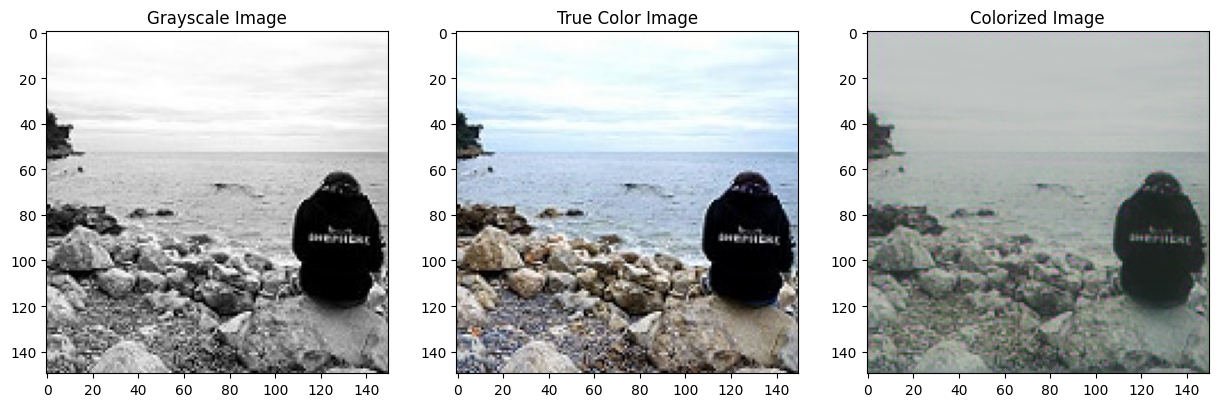

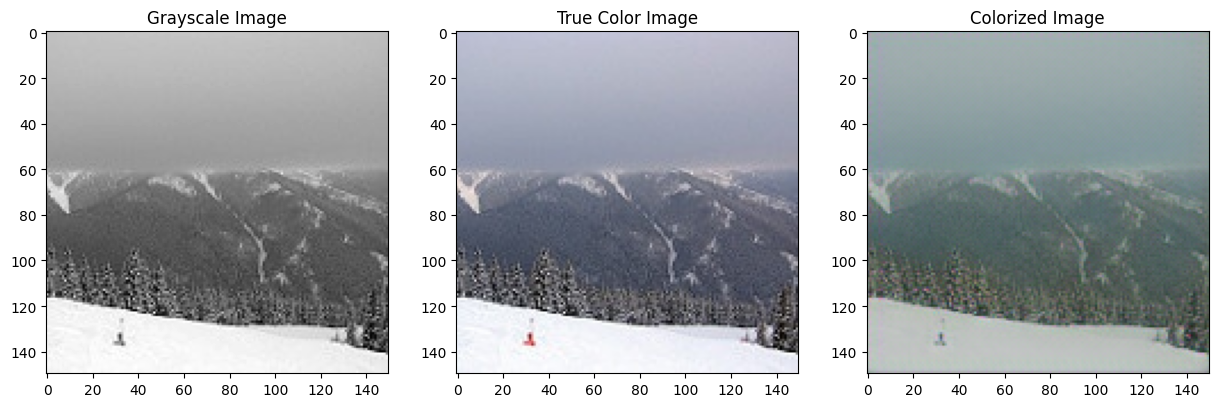

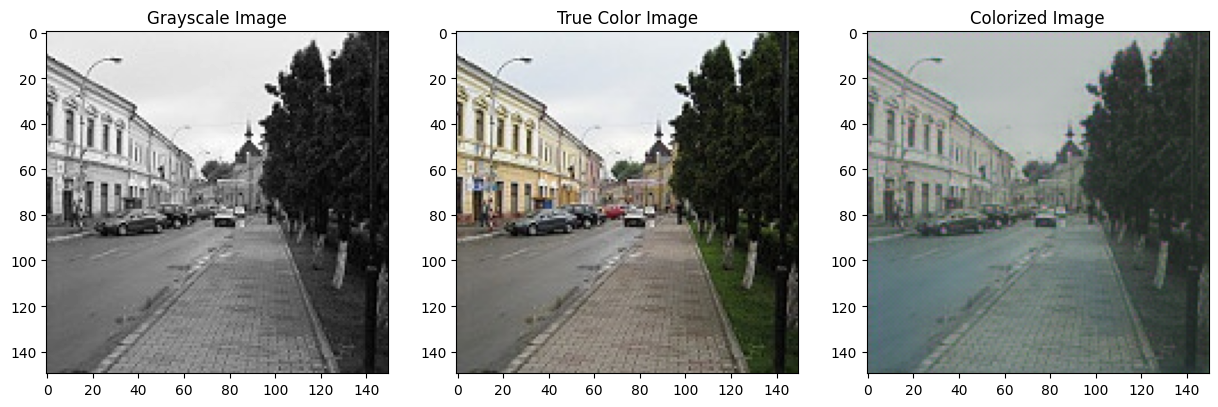

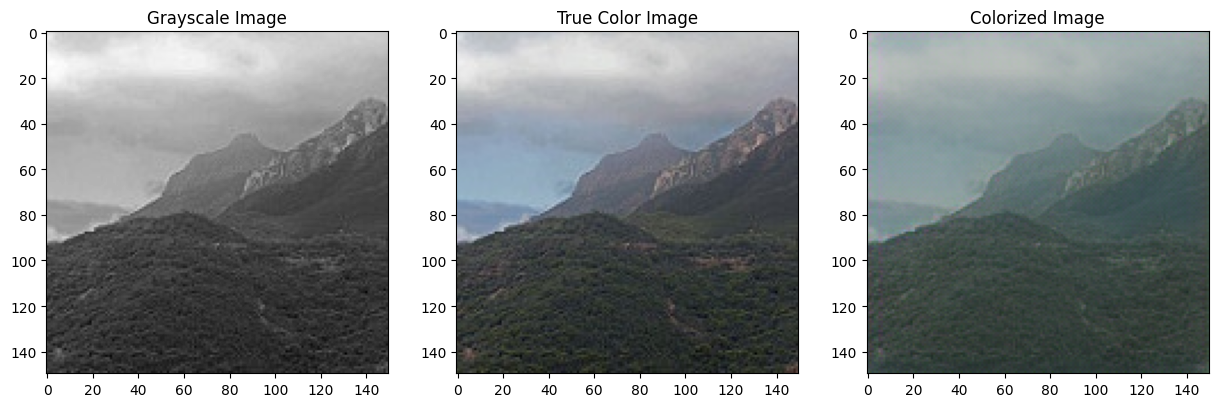

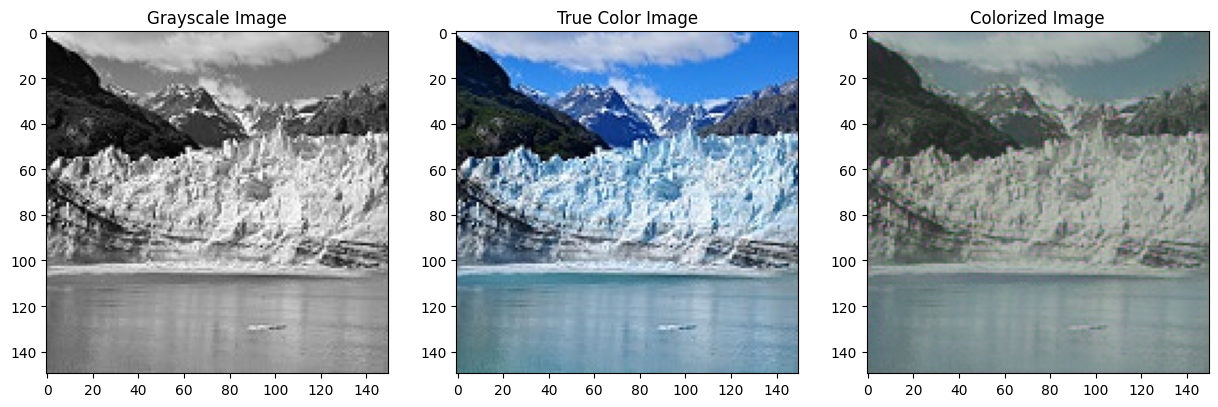

In [13]:
# Call the function to visualize model predictions on the test dataset
visualize_results(model, test_loader)

Despite efforts to address the dataset imbalance and optimize the training process, the results achieved represent the best possible given the limitations.